# Introduction

Previously we investigated ways to detect Covid-19 using biometric data generally referred to as vitals. The three metrics we looked at were Sp02, Pulse, and Temperature. We were able to generate a model that can predict with 95%+ accuracy if the user has Covid-19 or not using just these three metrics. We also decided that since Sp02 and Pulse are already tracked on an Apple Watch Series 6, a model that could evaluate based on just those two metrics would allow for an iOS app that monitors for Covid-19 without any activate effort from the user. We were able to generate a model with a 80% precision and 92% recall. This is high, but not good enough. I also am not certain if our model can differentiate between Covid-19 and the Flu. 

To overcome both these problems, we next will be exploring another dataset that takes lots of binary classification features and outputs a diagnosis of Cold, Flu, Allergies, and Covid-19. These features match potential symptoms the user may be experiencing such as cough, sore throad, etc. If we can accurately model these symptoms to a diagnosis, we can generate a system that accurately monitors and diagnosis Covid-19 for iOS users with an Apple Watch series 6. 

The proposal is to utilize the first model to monitor vitals in the background. If the model detects Covid-19, the user would be prompted to answer some further questions. These questions map to the dataset we are about to explore and could accurately help end users understand their health and make better informed decisions. 

In [1]:
# First I need to import my libraries

import numpy as np

import pandas as pd
from pandas.io.json import json_normalize
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import sklearn.metrics
from sklearn.preprocessing import LabelEncoder

import scipy.stats as stats
from scipy.stats import chi2_contingency

Each feature is a binary value of zero representing that the user is not experiencing that symptom and one if they are.

In [2]:
originalData_df = pd.read_csv('large_data.csv')
print("DataFrame shape: {}".format(originalData_df.shape))
originalData_df.head()

DataFrame shape: (44453, 21)


,COUGH,MUSCLE_ACHES,TIREDNESS,SORE_THROAT,RUNNY_NOSE,STUFFY_NOSE,FEVER,NAUSEA,VOMITING,DIARRHEA,SHORTNESS_OF_BREATH,DIFFICULTY_BREATHING,LOSS_OF_TASTE,LOSS_OF_SMELL,ITCHY_NOSE,ITCHY_EYES,ITCHY_MOUTH,ITCHY_INNER_EAR,SNEEZING,PINK_EYE,TYPE
0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,ALLERGY
1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,1,1,1,ALLERGY
2,0,1,1,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,ALLERGY
3,0,0,0,1,1,0,0,0,0,0,0,0,1,1,0,0,1,0,1,1,ALLERGY
4,0,0,1,0,1,0,0,0,0,0,0,0,1,1,0,1,0,1,1,1,ALLERGY


Looks like we have a very unbalanced dataset. This can be problematic for any model we attempt to build. Lets go ahead and only take 1024 records from each Type. We can use the entire dataset later on for testing our models.

** I originally set the amount of examples per targer class to 1024, but as I will discuss in the results section, the model failed to generalize to the larger dataset during testing. I was only getting about 50% precision for colds and Covid. If I set the sample size to 2048 per class, models are way more accurate as they must need more training data from the covid examples.

In [3]:
originalData_df['TYPE'].value_counts()

FLU        25000
ALLERGY    16381
COVID       2048
COLD        1024
Name: TYPE, dtype: int64

In [4]:
def sampling_k_elements(group, k=5000):
    if len(group) < k:
        return group
    return group.sample(k)

originalData_df = originalData_df.groupby('TYPE').apply(sampling_k_elements).reset_index(drop=True)
originalData_df.head()

,COUGH,MUSCLE_ACHES,TIREDNESS,SORE_THROAT,RUNNY_NOSE,STUFFY_NOSE,FEVER,NAUSEA,VOMITING,DIARRHEA,SHORTNESS_OF_BREATH,DIFFICULTY_BREATHING,LOSS_OF_TASTE,LOSS_OF_SMELL,ITCHY_NOSE,ITCHY_EYES,ITCHY_MOUTH,ITCHY_INNER_EAR,SNEEZING,PINK_EYE,TYPE
0,1,1,1,1,0,0,0,0,0,0,0,0,1,0,1,1,1,0,0,0,ALLERGY
1,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,ALLERGY
2,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,1,1,1,0,0,ALLERGY
3,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,ALLERGY
4,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,1,0,0,1,0,ALLERGY


The mean value for different symptoms. On average, half of data records had muscle aches, tiredness, sore throat, cough, and sneezing. Some values like itchyness and pink eye are rare on average. This might make them excellent indicators for a specific disease. 

In [5]:
describe_df = originalData_df.describe()
describe_df.loc['mean'].sort_values

<bound method Series.sort_values of COUGH                   0.516600
MUSCLE_ACHES            0.516218
TIREDNESS               0.514382
SORE_THROAT             0.508415
RUNNY_NOSE              0.427173
STUFFY_NOSE             0.437194
FEVER                   0.316172
NAUSEA                  0.283736
VOMITING                0.284578
DIARRHEA                0.285802
SHORTNESS_OF_BREATH     0.278840
DIFFICULTY_BREATHING    0.282130
LOSS_OF_TASTE           0.386551
LOSS_OF_SMELL           0.386475
ITCHY_NOSE              0.193467
ITCHY_EYES              0.195838
ITCHY_MOUTH             0.191707
ITCHY_INNER_EAR         0.189795
SNEEZING                0.513311
PINK_EYE                0.189489
Name: mean, dtype: float64>

Some noticable correlations:

1. all "itchy" symptoms correlate highly with each other
2. Fever shows some correlation with lots of other symptoms
3. Shortness of breath shows some correlation with lots of other symptoms

In [6]:
originalData_df.corr()

,COUGH,MUSCLE_ACHES,TIREDNESS,SORE_THROAT,RUNNY_NOSE,STUFFY_NOSE,FEVER,NAUSEA,VOMITING,DIARRHEA,SHORTNESS_OF_BREATH,DIFFICULTY_BREATHING,LOSS_OF_TASTE,LOSS_OF_SMELL,ITCHY_NOSE,ITCHY_EYES,ITCHY_MOUTH,ITCHY_INNER_EAR,SNEEZING,PINK_EYE
COUGH,1.000000,-0.006745,-0.002028,-0.010205,-0.001144,-0.003818,0.012145,0.008805,0.007548,0.013886,0.011263,0.012510,0.014655,0.010417,-0.014526,-0.020251,-0.012678,-0.009246,-0.001344,-0.014304
MUSCLE_ACHES,-0.006745,1.000000,0.000598,0.003741,-0.004506,-0.003760,0.014312,0.007249,0.008030,0.008948,0.015835,0.014350,0.019035,0.033344,-0.011050,-0.015244,-0.019694,-0.018245,0.000667,-0.017449
TIREDNESS,-0.002028,0.000598,1.000000,-0.009976,-0.003190,-0.001448,0.008249,0.012276,-0.002544,0.001446,0.004805,0.002367,0.015662,0.025883,-0.001500,-0.009186,-0.005071,-0.013342,-0.002910,-0.010984
SORE_THROAT,-0.010205,0.003741,-0.009976,1.000000,-0.006493,0.005679,0.008135,0.012997,0.018210,0.008319,0.017003,0.004069,0.017591,0.002667,-0.024707,-0.008692,-0.012473,-0.014976,0.006593,-0.029809
RUNNY_NOSE,-0.001144,-0.004506,-0.003190,-0.006493,1.000000,0.144257,-0.052052,-0.059821,-0.060350,-0.053027,-0.054849,-0.056498,0.144974,0.142256,0.043723,0.056676,0.076414,0.058834,0.007015,0.065464
STUFFY_NOSE,-0.003818,-0.003760,-0.001448,0.005679,0.144257,1.000000,-0.058348,-0.067582,-0.076685,-0.078974,-0.081360,-0.065580,0.145004,0.139447,0.068454,0.080359,0.071848,0.061478,0.009697,0.067714
FEVER,0.012145,0.014312,0.008249,0.008135,-0.052052,-0.058348,1.000000,0.270906,0.267209,0.267935,0.257756,0.259177,-0.090416,-0.093353,-0.333028,-0.335556,-0.331149,-0.329104,-0.000169,-0.328776
NAUSEA,0.008805,0.007249,0.012276,0.012997,-0.059821,-0.067582,0.270906,1.000000,0.334149,0.339150,0.337844,0.337693,-0.108626,-0.086577,-0.308257,-0.310598,-0.306518,-0.304625,0.002760,-0.304322
VOMITING,0.007548,0.008030,-0.002544,0.018210,-0.060350,-0.076685,0.267209,0.334149,1.000000,0.339544,0.331089,0.335468,-0.105832,-0.102255,-0.308895,-0.311241,-0.307153,-0.305256,-0.003228,-0.304952
DIARRHEA,0.013886,0.008948,0.001446,0.008319,-0.053027,-0.078974,0.267935,0.339150,0.339544,1.000000,0.318405,0.333714,-0.099848,-0.106012,-0.309824,-0.312177,-0.308076,-0.306174,0.007883,-0.305869


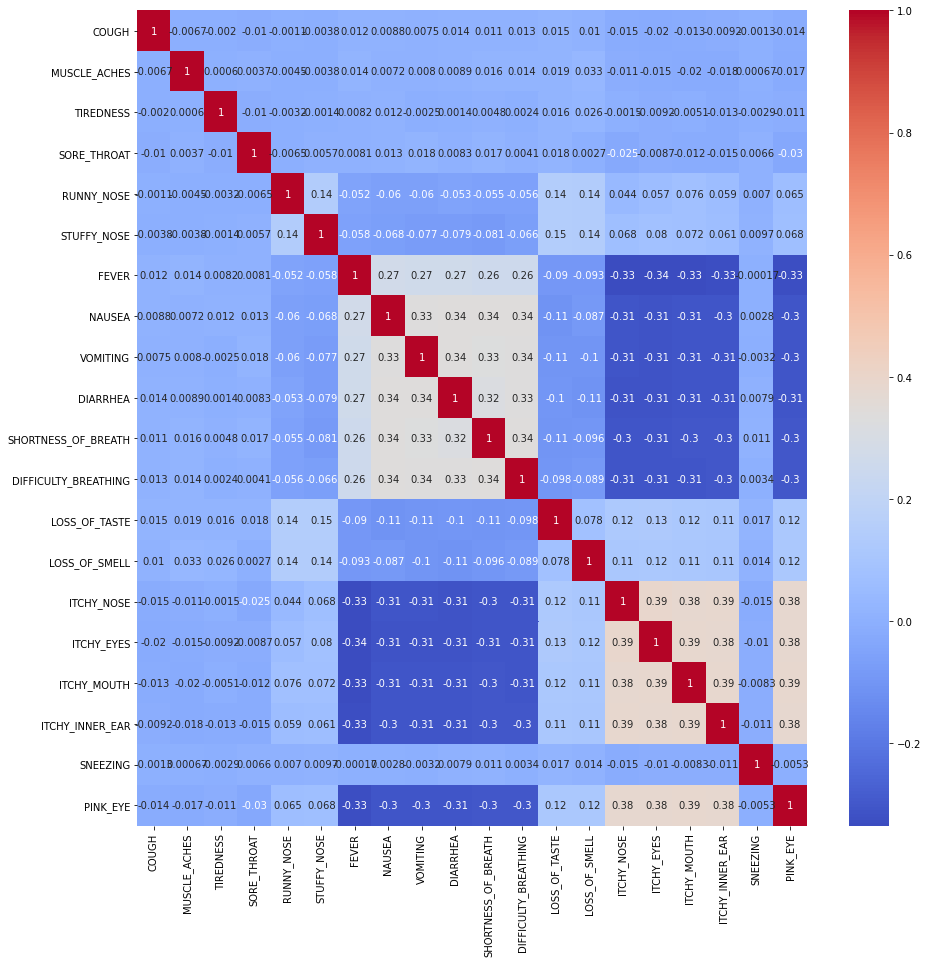

In [7]:
figure = plt.figure(figsize=(15,15))
sns.heatmap(originalData_df.corr(),annot=True, cmap='coolwarm')
plt.show()

Next, lets take a look at which symptoms present themselves based on the diagnosis. Here I display all categories where the symptom display at least once and order them from most occurences to least. As we can see, almost all symptoms display uniformly for each disease.

In [8]:
covid_df = originalData_df.loc[originalData_df['TYPE'] == 'COVID']
covid_df = covid_df.sum(axis='rows')
covid_df = covid_df.drop('TYPE')
covid_df.sort_values(ascending=False).head(12)

DIARRHEA                1024
SHORTNESS_OF_BREATH     1024
MUSCLE_ACHES            1024
TIREDNESS               1024
SORE_THROAT             1024
FEVER                   1024
NAUSEA                  1024
VOMITING                1024
SNEEZING                1024
COUGH                   1024
DIFFICULTY_BREATHING    1024
LOSS_OF_TASTE              0
dtype: object

In [9]:
flu_df = originalData_df.loc[originalData_df['TYPE'] == 'FLU']
flu_df = flu_df.sum(axis='rows')
flu_df = flu_df.drop('TYPE')
flu_df.sort_values(ascending=False).head(16)

COUGH                   2723
DIARRHEA                2712
MUSCLE_ACHES            2697
VOMITING                2696
NAUSEA                  2685
SORE_THROAT             2665
STUFFY_NOSE             2665
DIFFICULTY_BREATHING    2664
TIREDNESS               2662
SNEEZING                2649
RUNNY_NOSE              2642
SHORTNESS_OF_BREATH     2621
FEVER                   2597
LOSS_OF_SMELL           2041
LOSS_OF_TASTE           2016
ITCHY_INNER_EAR            0
dtype: object

In [10]:
cold_df = originalData_df.loc[originalData_df['TYPE'] == 'COLD']
cold_df = cold_df.sum(axis='rows')
cold_df = cold_df.drop('TYPE')
cold_df.sort_values(ascending=False).head(11)

COUGH            512
MUSCLE_ACHES     512
TIREDNESS        512
SORE_THROAT      512
RUNNY_NOSE       512
LOSS_OF_SMELL    512
LOSS_OF_TASTE    512
STUFFY_NOSE      512
FEVER            512
SNEEZING         512
NAUSEA             0
dtype: object

In [11]:
allergy_df = originalData_df.loc[originalData_df['TYPE'] == 'ALLERGY']
allergy_df = allergy_df.sum(axis='rows')
allergy_df = allergy_df.drop('TYPE')
allergy_df.sort_values(ascending=False).head(15)

ITCHY_EYES         2560
STUFFY_NOSE        2538
ITCHY_NOSE         2529
TIREDNESS          2526
LOSS_OF_TASTE      2525
SNEEZING           2525
MUSCLE_ACHES       2515
ITCHY_MOUTH        2506
LOSS_OF_SMELL      2499
COUGH              2494
ITCHY_INNER_EAR    2481
PINK_EYE           2477
SORE_THROAT        2445
RUNNY_NOSE         2430
NAUSEA                0
dtype: object

### Feature selection

Going to look for features that are greater than zero for one of the types but is not in all four dataframes as this will be the features that will help our models differentiate between diagnostics. Because our data is unique in that all four of these diseases present themselves in almost exactly the same way. 

In [12]:
def isUnique(col, df1, df2, df3, df4):
    if df1.loc[col] > 0 and df2.loc[col] > 0 and df3.loc[col] > 0 and df4.loc[col] > 0:
        return False
    return True

In [13]:
columns = set()

for col in flu_df.items():
    if isUnique(col[0], flu_df, allergy_df, cold_df, covid_df):
        columns.add(col[0])
        
for col in allergy_df.items():
    if isUnique(col[0], flu_df, allergy_df, cold_df, covid_df):
        columns.add(col[0])
        
for col in cold_df.items():
    if isUnique(col[0], flu_df, allergy_df, cold_df, covid_df):
        columns.add(col[0])
        
for col in covid_df.items():
    if isUnique(col[0], flu_df, allergy_df, cold_df, covid_df):
        columns.add(col[0])
print(columns)

{'VOMITING', 'FEVER', 'DIARRHEA', 'SHORTNESS_OF_BREATH', 'LOSS_OF_TASTE', 'DIFFICULTY_BREATHING', 'LOSS_OF_SMELL', 'ITCHY_NOSE', 'RUNNY_NOSE', 'NAUSEA', 'PINK_EYE', 'ITCHY_MOUTH', 'STUFFY_NOSE', 'ITCHY_INNER_EAR', 'ITCHY_EYES'}


Create a train dataframe that only has the features we want to train

In [14]:
train_df = originalData_df[columns]
train_df.shape

(13072, 15)

Need to take our target data and convert into categorical classes for our models to work with. 

In [15]:
originalData_df['TYPE_CODE'] = pd.Categorical(originalData_df['TYPE'])
originalData_df['TYPE_CODE'] = originalData_df['TYPE_CODE'].cat.codes
train_y = originalData_df['TYPE_CODE']

Splitting the data into train and test sets. I am making the test set small. This is because we removed the majority of our data to resolve it be unbalanced. But these records will be good for using as a test dataset, therefore we need less from our balanced dataset. 

In [16]:
X_train, X_test, y_train, y_test = train_test_split(train_df, train_y, test_size=0.15, random_state=4)

## Building a model

First model I want to try is a random forest. Because all of our data is binary classifications, a decision tree tends to do well at modeling clear and simply boundaries for classification. I am going with a random forest over a decision tree because they tend to be more accurate. Although they are slower than a decision tree, this is not much of a problem in this use case as scaling this model for production will not be an issue. 

In [17]:
from sklearn.ensemble import RandomForestClassifier
RFclassifier = RandomForestClassifier(n_estimators = 5, criterion = 'entropy', random_state = 5)
RFclassifier.fit(X_train, y_train)

/Users/christopherweaver/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=1,
            oob_score=False, random_state=5, verbose=0, warm_start=False)

This code is just to print out labels for our confusion matrix below

In [18]:
label_encoder = LabelEncoder()                               
label_encoder.fit_transform(originalData_df['TYPE'])
keys = label_encoder.classes_  
values = label_encoder.transform(label_encoder.classes_)
dictionary = dict(zip(keys, values))

Our confusion matrix shows that we have perfect precision for allergies and the flu and 92% for the cold and covid. More importantly, recall for Covid is at 95% and above 90% for the rest. Our main goal is to avoid false negatives.

In [19]:
from sklearn.metrics import confusion_matrix

y_pred = RFclassifier.predict(X_test)
accuracyRF = sklearn.metrics.accuracy_score(y_test, y_pred)

print(dictionary)
print(confusion_matrix(y_test,y_pred))
print(sklearn.metrics.classification_report(y_test,y_pred))

{'ALLERGY': 0, 'COLD': 1, 'COVID': 2, 'FLU': 3}
[[726  20   2   0]
 [  0 170   7   0]
 [  0   3 309   0]
 [  0   6  66 652]]
             precision    recall  f1-score   support

          0       1.00      0.97      0.99       748
          1       0.85      0.96      0.90       177
          2       0.80      0.99      0.89       312
          3       1.00      0.90      0.95       724

avg / total       0.96      0.95      0.95      1961



Next going to try a suppor vector machine. SVM's tend to work well when there is a clear margin between classes which my initial data analysis seemed to show.

Again, high precision and recall for all diseases. These results actually match what we saw for the random forest model. 

In [20]:
from sklearn.svm import SVC
svclassifier = SVC(kernel='rbf', C=1.0)
svclassifier.fit(X_train, y_train)
y_pred = svclassifier.predict(X_test)
print(dictionary)
print(sklearn.metrics.confusion_matrix(y_test,y_pred))
print(sklearn.metrics.classification_report(y_test,y_pred))

{'ALLERGY': 0, 'COLD': 1, 'COVID': 2, 'FLU': 3}
[[726  20   2   0]
 [  0 166  11   0]
 [  0   0 312   0]
 [  0   6  66 652]]
             precision    recall  f1-score   support

          0       1.00      0.97      0.99       748
          1       0.86      0.94      0.90       177
          2       0.80      1.00      0.89       312
          3       1.00      0.90      0.95       724

avg / total       0.96      0.95      0.95      1961



lets grab the entire dataset and use it as a test dataset to further validate these models. Ideally, I should try to remove the records we used for training, but since it was a small fraction of the entire dataset and since they were randomly choosen, I am just going to use them all. 

In [21]:
finalTest_df = pd.read_csv('large_data.csv')
finalTest_df['TYPE_CODE'] = pd.Categorical(finalTest_df['TYPE'])
finalTest_df['TYPE_CODE'] = finalTest_df['TYPE_CODE'].cat.codes
finalTest_y = finalTest_df['TYPE_CODE']
finalTest_df = finalTest_df[columns]
finalTest_x = finalTest_df.values
finalTest_df.shape

(44453, 15)

First lets test our random forest model. 

In [22]:
y_pred = RFclassifier.predict(finalTest_x)
accuracyRF = sklearn.metrics.accuracy_score(finalTest_y, y_pred)
print(dictionary)
print(sklearn.metrics.confusion_matrix(finalTest_y, y_pred))
print(sklearn.metrics.classification_report(finalTest_y, y_pred))

{'ALLERGY': 0, 'COLD': 1, 'COVID': 2, 'FLU': 3}
[[15870   479    32     0]
 [    0   992    32     0]
 [    0    32  2016     0]
 [    0   431  1958 22611]]
             precision    recall  f1-score   support

          0       1.00      0.97      0.98     16381
          1       0.51      0.97      0.67      1024
          2       0.50      0.98      0.66      2048
          3       1.00      0.90      0.95     25000

avg / total       0.97      0.93      0.94     44453



In [23]:
y_pred = svclassifier.predict(finalTest_x)
print(dictionary)
print(" ")
print(sklearn.metrics.confusion_matrix(finalTest_y, y_pred))
print(" ")
print(sklearn.metrics.classification_report(finalTest_y, y_pred))

{'ALLERGY': 0, 'COLD': 1, 'COVID': 2, 'FLU': 3}
 
[[15870   479    32     0]
 [    0   960    64     0]
 [    0     0  2048     0]
 [    0   405  1984 22611]]
 
             precision    recall  f1-score   support

          0       1.00      0.97      0.98     16381
          1       0.52      0.94      0.67      1024
          2       0.50      1.00      0.66      2048
          3       1.00      0.90      0.95     25000

avg / total       0.97      0.93      0.94     44453



My models were able to differentiate between all four diagnosis with perfect accuracy.  